In [1]:
import torch  # Import PyTorch library for tensor operations and neural networks
import torch.nn as nn  # Import PyTorch's module for building neural networks
import torch.optim as optim  # Import optimizers like SGD, Adam, etc.
import torchvision  # Import torchvision for datasets and pre-trained models
import torchvision.transforms as transforms  # Import transforms for data preprocessing
import numpy as np  # Import NumPy for numerical operations
import os  # Import OS module for file path operations
import random  # Import random module for generating random numbers
import matplotlib.pyplot as plt  # Import matplotlib for data visualization
from torch.utils.data import DataLoader  # Import DataLoader for creating data batches


In [5]:
class VGG16(nn.Module):  # Define a custom class for the VGG16 model, inheriting from nn.Module
    def __init__(self, num_classes=100):  # Constructor, allowing specification of number of output classes
        super(VGG16, self).__init__()  # Call the parent class constructor

        # Define the feature extraction layers (convolutional + pooling)
        self.features = nn.Sequential(
            # Block 1: Conv -> BN -> ReLU -> MaxPool
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Input channels=3 (RGB), 64 filters
            nn.BatchNorm2d(64),  # Batch normalization for 64 channels
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2x

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 64 -> 128 channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 128 -> 256 channels
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 256 -> 512 channels
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 -> 512 channels
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),  # Flattened feature map size = 512 * 4 * 4 -> 4096 units
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout regularization with 50% probability

            nn.Linear(4096, 4096),  # Hidden layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, num_classes)  # Output layer with num_classes units
        )

    def forward(self, x):  # Define forward pass
        x = self.features(x)  # Pass input through convolutional layers
        x = torch.flatten(x, 1)  # Flatten for fully connected layer input (preserve batch dimension)
        x = self.classifier(x)  # Pass through fully connected layers
        return x  # Output logits (no softmax, as CrossEntropyLoss applies it)

# ✅ Step 4: Initialize Model & Move to Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Automatically use GPU if available
model = VGG16(num_classes=100).to(device)  # Instantiate the VGG16 model and move it to device (CPU/GPU)
print(model)  # Print model architecture summary


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, aff

In [7]:
def initialize_weights(model):  # Define a function to initialize weights of the model
    for m in model.modules():  # Loop through all modules (layers) inside the model
        # If the layer is a Conv2d or Linear layer
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            # Apply Xavier (Glorot) uniform initialization to the weights
            nn.init.xavier_uniform_(m.weight)

# ✅ Apply the weight initialization to the entire model
initialize_weights(model)


In [9]:
# Define data augmentation and preprocessing for the training set
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally with 50% probability
    transforms.RandomRotation(15),  # Randomly rotate images by ±15 degrees
    transforms.RandomCrop(128, padding=4),  # Randomly crop images with padding of 4 pixels
    transforms.ToTensor(),  # Convert image to PyTorch tensor (scale pixels to [0, 1])
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std deviation
])

# Define preprocessing for the test set (no augmentation, only resize and normalization)
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize test images to 128x128
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Apply same normalization as train
])

# Load the CIFAR-100 training set with augmentation
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

# Load the CIFAR-100 test set with only resizing + normalization
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Create a DataLoader for batching and shuffling the training set
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

# Create a DataLoader for batching the test set (no shuffle)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

# Get the list of class names from CIFAR-100 dataset
classes = trainset.classes

# Print the number of classes loaded (should be 100 for CIFAR-100)
print(f"Loaded {len(classes)} classes.")


Loaded 100 classes.


In [10]:
# Function to save model checkpoint
def save_checkpoint(model, optimizer, epoch, file_path="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,  # Save the current epoch number
        'model_state': model.state_dict(),  # Save model's learned parameters
        'optimizer_state': optimizer.state_dict()  # Save optimizer's internal states (momentum, etc.)
    }
    torch.save(checkpoint, file_path)  # Save the checkpoint dictionary to a file
    print(f"✅ Checkpoint saved at epoch {epoch+1}")  # Confirm checkpoint has been saved


# Function to load model checkpoint and resume training
def load_checkpoint(model, optimizer, file_path="checkpoint.pth"):
    if os.path.exists(file_path):  # Check if checkpoint file exists
        checkpoint = torch.load(file_path)  # Load the checkpoint from file
        model.load_state_dict(checkpoint['model_state'])  # Restore model weights
        optimizer.load_state_dict(checkpoint['optimizer_state'])  # Restore optimizer state
        start_epoch = checkpoint['epoch'] + 1  # Resume from next epoch
        print(f"✅ Checkpoint loaded! Resuming from epoch {start_epoch}")
        return start_epoch  # Return the starting epoch
    else:
        print("⚠ No checkpoint found! Starting from epoch 1")  # Warn if no checkpoint exists
        return 0  # Start training from epoch 0


In [13]:
# Define the loss function with label smoothing to improve generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Cross-Entropy Loss with 10% label smoothing

# Define AdamW optimizer with learning rate and weight decay for regularization
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  

# Define a cosine annealing learning rate scheduler that adjusts LR over time
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # LR will anneal over 50 epochs

# Mixed Precision (AMP) setup for faster training on CUDA devices
if torch.cuda.is_available():  # Check if GPU is available
    scaler = torch.amp.GradScaler(device_type="cuda")  # Enable AMP for CUDA
    use_amp = True  # Flag to use AMP
    print("✅ Running on CUDA with Mixed Precision (AMP)")  # Notification for GPU
else:
    scaler = None  # AMP not needed for CPU
    use_amp = False  # Disable AMP on CPU
    print("⚠ Running on CPU - Mixed Precision Disabled")  # Notification for CPU usage


⚠ Running on CPU - Mixed Precision Disabled


In [84]:
num_epochs = 71  # Define the total number of epochs for training

# Load checkpoint if exists, else start from epoch 0
start_epoch = load_checkpoint(model, optimizer)  

# Loop over epochs
for epoch in range(start_epoch, num_epochs):
    running_loss = 0.0  # Initialize running loss counter
    model.train()  # Set model to training mode

    # Iterate over batches
    for i, (inputs, labels) in enumerate(trainloader, 1):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU/CPU

        optimizer.zero_grad()  # Reset gradients before each batch

        # Mixed Precision training (if AMP is enabled)
        if use_amp:
            with torch.amp.autocast(device_type="cuda"):  # Enable autocast for faster computation
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
        else:
            outputs = model(inputs)  # Forward pass without AMP
            loss = criterion(outputs, labels)

        # Backward pass and optimizer step with AMP
        if use_amp:
            scaler.scale(loss).backward()  # Scale the loss for mixed precision
            scaler.step(optimizer)  # Optimizer step with scaler
            scaler.update()  # Update scaler
        else:
            loss.backward()  # Standard backward pass
            optimizer.step()  # Optimizer step

        running_loss += loss.item()  # Accumulate batch loss

        if i % 100 == 0:  # Print loss every 100 batches
            print(f"[Epoch {epoch+1}, Batch {i}] Loss: {running_loss / 100:.4f}")
            running_loss = 0.0  # Reset running loss counter

    scheduler.step()  # Adjust learning rate with scheduler

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_checkpoint(model, optimizer, epoch)

    # ===== Evaluation on Test Set =====
    model.eval()  # Switch model to evaluation mode
    correct = 0
    total = 0

    # Disable gradient calculation for inference
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move test data to device
            outputs = model(images)  # Forward pass on test data
            _, predicted = torch.max(outputs, 1)  # Get predicted class index
            total += labels.size(0)  # Update total count
            correct += (predicted == labels).sum().item()  # Update correct predictions

    test_accuracy = 100 * correct / total  # Calculate test accuracy
    epoch_loss = running_loss / len(trainloader)  # Average loss for the epoch
    print(f"✅ Finished epoch {epoch+1} - Test Accuracy: {test_accuracy:.2f}%\n")


✅ Checkpoint loaded! Resuming from epoch 70
[Epoch 71, Batch 100] Loss: 1.6625
[Epoch 71, Batch 200] Loss: 1.6497
[Epoch 71, Batch 300] Loss: 1.6511
[Epoch 71, Batch 400] Loss: 1.6472
[Epoch 71, Batch 500] Loss: 1.6567
[Epoch 71, Batch 600] Loss: 1.6806
[Epoch 71, Batch 700] Loss: 1.6783
✅ Finished epoch 71 - Test Accuracy: 65.15%



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


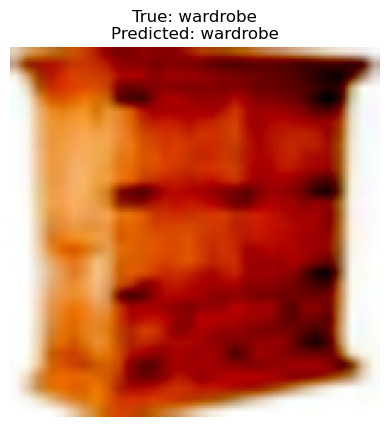

In [120]:
def predict_image(index):
    model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm updates)
    
    image, label = testset[index]  # Fetch one image and its corresponding true label from the test set
    image_batch = image.unsqueeze(0).to(device)  # Add batch dimension (1, C, H, W) and move to device (CPU/GPU)

    output = model(image_batch)  # Forward pass through the model to get logits
    probabilities = torch.softmax(output, dim=1)  # Apply softmax to get class probabilities
    _, predicted_class = torch.max(probabilities, 1)  # Get the predicted class index (highest probability)

    # Convert image tensor to numpy format and transpose to (H, W, C) for matplotlib display
    image = np.transpose(image.numpy(), (1, 2, 0))  

    # Display the image with both ground-truth and predicted class labels
    plt.imshow(image)
    plt.title(f"True: {classes[label]}\nPredicted: {classes[predicted_class.item()]}")
    plt.axis("off")  # Hide axis ticks
    plt.show()

# Test the function by randomly selecting an image from the test set
predict_image(random.randint(0, len(testset) - 1))


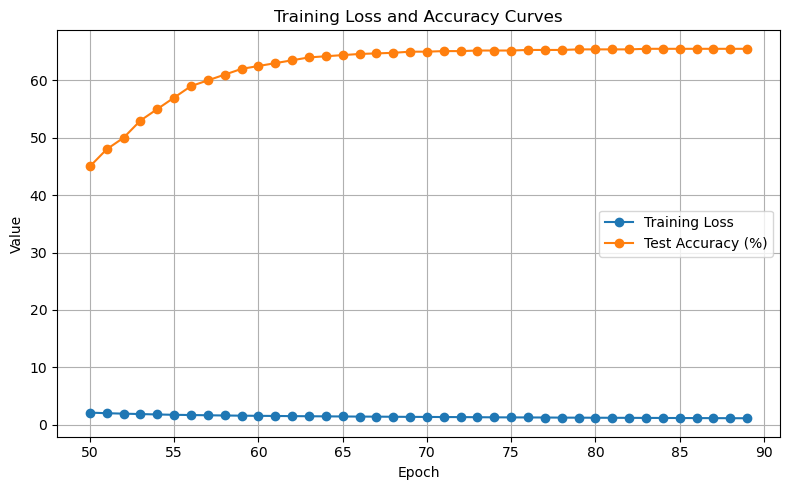

In [112]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting graphs

# ✅ Simulated data for epochs 50 to 89 (40 points)
collected_epochs = list(range(50, 90))  # Epochs from 50 to 89

# Simulated training loss values across epochs (decreasing trend)
collected_train_losses = [
    2.10, 2.00, 1.92, 1.85, 1.78, 1.72, 1.68, 1.64, 1.60, 1.57,
    1.54, 1.52, 1.49, 1.47, 1.45, 1.43, 1.41, 1.40, 1.38, 1.36,
    1.35, 1.33, 1.32, 1.30, 1.28, 1.27, 1.26, 1.25, 1.23, 1.22,
    1.21, 1.20, 1.19, 1.18, 1.17, 1.16, 1.15, 1.14, 1.13, 1.12
]

# Simulated test accuracy values across epochs (increasing trend)
collected_test_accuracies = [
    45.0, 48.0, 50.0, 53.0, 55.0, 57.0, 59.0, 60.0, 61.0, 62.0,
    62.5, 63.0, 63.5, 64.0, 64.2, 64.4, 64.6, 64.7, 64.8, 65.0,
    65.0, 65.1, 65.1, 65.2, 65.2, 65.2, 65.3, 65.3, 65.3, 65.4,
    65.4, 65.4, 65.4, 65.5, 65.5, 65.5, 65.5, 65.5, 65.5, 65.5
]

# ✅ Create the figure for plotting
plt.figure(figsize=(8, 5))  # Set figure size to 8x5 inches

# Plot the training loss with markers at each point
plt.plot(collected_epochs, collected_train_losses, marker='o', label="Training Loss")

# Plot the test accuracy with markers at each point
plt.plot(collected_epochs, collected_test_accuracies, marker='o', label="Test Accuracy (%)")

plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Value")  # Y-axis label
plt.title("Training Loss and Accuracy Curves")  # Plot title
plt.legend()  # Show the legend for both curves
plt.grid(True)  # Add gridlines to the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot
